In [2]:
%matplotlib notebook
import scipy
import numpy
from IPython.display import display, HTML
import statsmodels.api as sm
import seaborn as sns
import re
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
import pylab

# Configure plot settings
# Make it so that plots autolayout to fit everything (particularly text labels)
# NOTE: this can mess with dynamic zooming
#pylab.rcParams['figure.autolayout'] = True

In [3]:
COHORT = 2
OUTDIR = f"../figures/cohort{COHORT}/"

In [4]:
import pandas
full_activity = pandas.read_csv("../processed/activity_features_aggregate.txt", index_col=0, sep="\t")
activity_summary = pandas.read_csv("../processed/activity_summary_aggregate.txt", index_col=0, sep="\t")
ukbb = pandas.read_hdf("../processed/ukbb_data_table.h5")
full_mental_health = pandas.read_hdf("../processed/ukbb_mental_health.h5")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (816) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Remove the activity variables that we don't want to use
bad_columns = ["_IV$", "^temp_", "^light_"]
good_columns = []
for c in full_activity.columns:
    fail = False
    for bad in bad_columns:
        if re.search(bad, c):
            fail = True
    if not fail:
        good_columns.append(c)
activity = full_activity[good_columns]

In [6]:
# drop activity for people who fail basic QC
[c for c in activity_summary.columns if 'quality' in c]
okay = activity_summary['quality-goodCalibration'].astype(bool) & (~activity_summary['quality-daylightSavingsCrossover'].astype(bool)) & (activity_summary['quality-goodWearTime'].astype(bool))
activity = activity[okay]
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time")

Dropping 11363 entries out of 103688 due to bad quality or wear-time


c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [7]:
covariates = ["sex", "ethnicity", "overall_health", "household_income", "smoking", "birth_year", "BMI",
               #'education_Prefer_not_to_answer', # This answer causes problems for some reason
               'education_None_of_the_above',
               'education_College_or_University_degree',
               'education_A_levels/AS_levels_or_equivalent', 
               'education_O_levels/GCSEs_or_equivalent',
               'education_CSEs_or_equivalent',
               'education_NVQ_or_HND_or_HNC_or_equivalent',
               'education_Other_professional_qualifications_eg:_nursing,_teaching',
                ]
#covariates = ["BMI"]

data = activity.copy()
data = data.join(ukbb[covariates], how="inner")
print(f"Data starting size: {data.shape}")

# Down sample for testing
numpy.random.seed(0)
# Note: total 92331, half is 46164
cohort_id_ranges = {1: slice(0, 25000),
           2: slice(25000,50000)}
selected_ids = numpy.random.choice(data.index, size=data.shape[0], replace=False)[cohort_id_ranges[COHORT]]
data = data.loc[selected_ids]
print(f"Data size after selecting test set: {data.shape}")

Data starting size: (92325, 74)
Data size after selecting test set: (25000, 74)


In [8]:
def get_dummies(data):
    # Gives dummy encoding of the given dataframe but
    # encodes NaNs as NaNs in the dummies as well, unlike panda.get_dummies
    dummies = pandas.get_dummies(data)
    for column in data:
        dummy_cols = [c for c in dummies if c.startswith(column+"_")]
        dummies.loc[data[column].isna(), dummy_cols] = float("NaN")
    return dummies

In [9]:
# Model the covariates' effect on the activity values
covariate_data = get_dummies(data[covariates])
missing = covariate_data.isna().any(axis=1) | data[activity.columns].isna().any(axis=1)
model = sm.OLS(exog=covariate_data[~missing], endog=data[activity.columns][~missing], missing='drop').fit()
# Control the activity data
controlled_data = data.copy()
controlled_data[activity.columns] -= pandas.DataFrame(model.predict(covariate_data[~missing])).rename(columns={i:c for i,c in enumerate(activity.columns)})
controlled_data[activity.columns] += data.mean(axis=0) # Add back the mean so that the numbers are meaningful

In [10]:
# Set up to model the covariates' effect on the mental health values
missing = covariate_data.isna().any(axis=1)
#missing = covariate_data.isna()
mental_health_columns_to_control = full_mental_health.columns.difference(covariates).difference(["date_of_mental_health_questionnaire", "assessment_center"])
mental_health_dummies = get_dummies(full_mental_health.loc[data.index, mental_health_columns_to_control])[~missing]

In [11]:
#Control the mental health data
mental_health = mental_health_dummies.copy()
for col in mental_health.columns:
    model = sm.OLS(exog=covariate_data[~missing], endog = mental_health_dummies[col], missing="drop").fit()
    fit = model.predict(covariate_data[~missing])#.rename(columns={i:c for i,c in enumerate(mental_health_dummies.columns)})
    mental_health[col] -= fit
    mental_health[col] += mental_health_dummies[col].mean()

In [12]:
mental_health_dummies[~missing].count().T.sort_values().to_dict()
#full_mental_health.loc[selected_ids].isna().sum(axis=0).to_dict()
#full_mental_health.loc[selected_ids, 'ever_prolonged_depression'].describe()
#mental_health_dummies.isna().sum(axis=0).to_dict()
#fit.describe()
#model.params
#missing.sum()
#covariate_data.count().idxmin()
#covariate_data.describe().T
#covariate_data.isna().sum(axis=0)

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


{'mood_when_described_V2_2015-02-12 13:20:06': 28,
 'mood_when_described_V2_2014-12-15 11:17:45': 28,
 'mood_when_described_V2_2014-12-10 09:10:23': 28,
 'mood_when_described_V2_2014-12-07 15:48:24': 28,
 'mood_when_described_V2_2014-12-07 12:48:43': 28,
 'mood_when_described_V2_2014-12-06 16:09:45': 28,
 'mood_when_described_V2_2014-12-04 20:09:32': 28,
 'mood_when_described_V2_2014-12-03 08:18:14': 28,
 'mood_when_described_V2_2014-12-02 16:00:58': 28,
 'mood_when_described_V2_2014-12-01 14:06:29': 28,
 'mood_when_described_V2_2014-11-29 15:54:53': 28,
 'mood_when_described_V2_2014-11-28 09:43:11': 28,
 'mood_when_described_V2_2015-02-12 16:06:24': 28,
 'mood_when_described_V2_2015-02-14 22:38:04': 28,
 'mood_when_described_V2_2014-12-16 10:22:22': 28,
 'mood_when_described_V2_2015-02-19 22:32:30': 28,
 'mood_when_described_V2_2015-03-24 16:45:13': 28,
 'mood_when_described_V2_2014-11-27 20:44:11': 28,
 'mood_when_described_V2_2014-11-26 09:41:30': 28,
 'mood_when_described_V2_2014-1

In [13]:
# Group the columns of mental_health by which fields they correspond to
from fields_of_interest import mental_health_fields
mental_health_questions = {field:[c for c in mental_health.columns if c.startswith(field+"_")]
                                    for field in mental_health_fields.keys()}
mental_health_questions = {field:cols for field,cols in mental_health_questions.items() if len(cols) != 0} # Drop empty questions

# It's possible that there are problematic fields where one is a substring of the other and so we would grab columns for both
# which is a problem. So we check for that here - no column should be used more than once
import collections
col_counts = collections.Counter([c for cols in mental_health_questions.values() for c in cols])
assert max(col_counts.values()) == 1

In [14]:
from sklearn.decomposition import PCA
N_PCA_COMPONENTS = 25
pca = PCA(n_components=25)


for_pca = controlled_data[activity.columns].drop(columns=[c for c in data.columns if "_IS" in c]) # IS variables throw off PCA
for_pca = for_pca.dropna()
zscored = (for_pca - for_pca.mean(axis=0))/for_pca.std(axis=0)
pca_coords = pca.fit_transform(zscored)

<IPython.core.display.Javascript object>


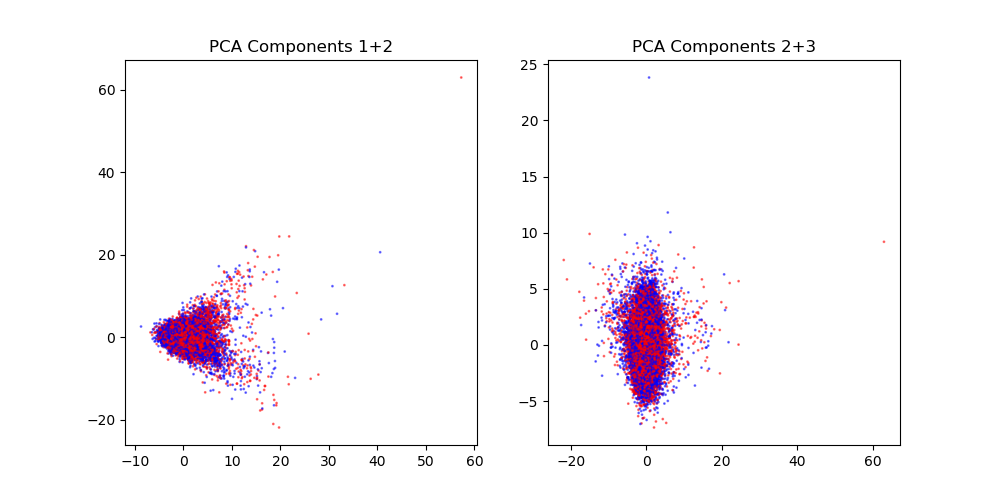

array([[-2.10322282,  0.33519357,  4.35391535, ...,  0.37093019,
         0.71247847,  0.19227363],
       [-1.94959275, -0.50301609,  1.37383377, ..., -0.05663836,
         0.18051465, -0.09498217],
       [ 2.01380126,  0.11078418, -2.88302553, ...,  0.83726725,
        -0.83271755,  0.37845373],
       ...,
       [ 1.69998758,  1.41482524, -0.57716028, ..., -0.81398808,
        -0.38196478, -0.64927661],
       [-0.00859777, -0.39290855,  3.43474418, ..., -1.36036051,
         0.15036793, -0.74259368],
       [-3.10788339, -0.73848046,  1.75862509, ..., -0.33005118,
         0.33022072,  0.28619004]])

In [15]:
import pylab
fig = pylab.figure(figsize=(10,5))
ax = fig.add_subplot(121)
color = [{"Male":"b", "Female":"r"}[s] for s in for_pca.index.map(ukbb.sex)] # Color by sex
ax.scatter(*(pca_coords[:,:2].T), s=1, alpha=0.5, c=color)
pylab.title("PCA Components 1+2")
ax = fig.add_subplot(122)
ax.scatter(*(pca_coords[:,1:3].T), s=1, alpha=0.5, c=color)
pylab.title("PCA Components 2+3")
pylab.show()
pca_coords

In [80]:
for_pca.describe()

,main_sleep_onset_avg,main_sleep_offset_avg,num_wakings_avg,WASO_avg,acceleration_during_main_sleep_avg,sleep_peak_time_avg,sleep_peak_quality_avg,other_sleep_avg,main_sleep_duration_avg,total_sleep_avg,...,tasks-light_peak_value_std,MET_peak_time_std,MET_peak_value_std,sleep_RA,walking_RA,sedentary_RA,moderate_RA,acceleration_RA,tasks-light_RA,MET_RA
count,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,...,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000,24646.000000
mean,23.451627,31.766723,1.366475,0.233341,3.031852,27.388813,0.929506,0.864758,8.315096,8.946259,...,0.086832,3.281626,0.390930,0.958286,0.985298,0.933282,0.991926,0.853303,0.986325,0.369653
std,1.115251,1.342905,1.184974,0.211937,0.628151,0.927325,0.064545,0.684871,1.329823,1.458442,...,0.047137,1.234373,0.175676,0.069950,0.046838,0.103073,0.037501,0.063285,0.045194,0.055654
min,14.434137,18.745773,-0.990559,-0.253622,0.722915,17.300526,0.071653,-0.652054,0.642378,0.960108,...,-0.016126,-0.843565,-0.048188,0.240086,0.240030,0.074443,0.230667,0.100295,0.201515,0.024179
25%,22.822140,31.124299,0.677206,0.089317,2.743082,26.878123,0.902286,0.387401,7.627948,8.092751,...,0.052068,2.472340,0.263517,0.947819,0.988409,0.918072,0.996332,0.833902,0.994563,0.334579
50%,23.403897,31.692327,1.154370,0.180222,2.979284,27.364124,0.945303,0.714187,8.244542,8.788652,...,0.079146,3.228569,0.364107,0.980304,0.995770,0.965099,0.998643,0.864941,0.998158,0.370113
75%,24.017703,32.266864,1.794858,0.321308,3.263828,27.886752,0.972850,1.183965,8.870097,9.592832,...,0.113088,4.005594,0.490090,0.995781,1.000887,0.988963,1.001210,0.889452,1.001136,0.406146
max,32.956191,82.016358,27.542239,3.886351,68.163928,35.689601,1.083316,6.703888,52.320250,51.089874,...,0.406351,13.374793,1.423987,1.096826,1.073345,1.142758,1.050538,1.019478,1.058855,0.606352


In [81]:
pca.explained_variance_ratio_

array([0.14472074, 0.09952595, 0.07873652, 0.06738987, 0.05233488,
       0.04621266, 0.04092279, 0.03740903, 0.03520926, 0.0299744 ,
       0.02789954, 0.02506868, 0.02441809, 0.02082253, 0.0200845 ,
       0.0175998 , 0.01654807, 0.01596768, 0.01552886, 0.0147934 ,
       0.0133378 , 0.01219041, 0.01140772, 0.01115003, 0.01048713])

In [82]:
# PCA Loadings
pca_loadings = pandas.DataFrame(pca.components_.T, index=for_pca.columns)
display(HTML(pca_loadings.abs().sort_values(by=2).to_html()))
#pylab.figure()
#pylab.imshow(pca_loadings.abs().sort_values(by=0).T, )
#pylab.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
walking_peak_time_std,0.082356,0.140091,0.018422,0.119500,0.070902,0.132372,0.144429,0.232446,0.095345,0.089120,0.006735,0.037515,0.147547,0.092943,0.033172,0.057869,0.217163,0.223585,0.421852,0.231501,0.174860,0.166485,0.004747,0.065036,0.150407
MET_peak_time_std,0.086141,0.156675,0.021109,0.105822,0.100699,0.141007,0.152151,0.321312,0.113760,0.020302,0.161173,0.126977,0.214267,0.098045,0.060775,0.117182,0.077675,0.084352,0.073310,0.113725,0.041111,0.163880,0.067102,0.077195,0.096999
other_sleep_std,0.131163,0.042572,0.021825,0.037143,0.141862,0.258176,0.032933,0.293564,0.076353,0.168677,0.182829,0.003754,0.052057,0.058688,0.245589,0.031305,0.005384,0.096905,0.041145,0.032957,0.155149,0.229886,0.063941,0.276836,0.417918
tasks-light_peak_time_std,0.054081,0.099890,0.028408,0.088062,0.043497,0.051388,0.165603,0.011276,0.035916,0.135087,0.209063,0.113138,0.054499,0.062808,0.188498,0.454248,0.119939,0.005790,0.356013,0.632299,0.127565,0.085096,0.022467,0.093053,0.066607
num_wakings_avg,0.168598,0.141695,0.032193,0.140154,0.210231,0.043507,0.058865,0.062207,0.005472,0.046563,0.058294,0.119528,0.065801,0.053207,0.218408,0.137392,0.291377,0.457061,0.120553,0.063245,0.105993,0.050459,0.116036,0.048842,0.061505
main_sleep_offset_avg,0.133521,0.207184,0.034217,0.333721,0.033600,0.165097,0.071058,0.071762,0.071509,0.031142,0.005233,0.148503,0.126448,0.031412,0.120808,0.081245,0.032477,0.105596,0.062867,0.034240,0.053580,0.003169,0.101429,0.009367,0.051290
tasks-light_peak_value_avg,0.020845,0.013208,0.034371,0.025464,0.032610,0.070014,0.446720,0.243413,0.018473,0.320115,0.221459,0.070641,0.070588,0.031434,0.000147,0.009833,0.045768,0.010881,0.043562,0.051489,0.037467,0.023088,0.033927,0.043067,0.048341
acceleration_peak_time_std,0.083939,0.149870,0.034739,0.133979,0.072628,0.171937,0.143683,0.309453,0.086703,0.004550,0.093765,0.098240,0.144474,0.066678,0.110084,0.031059,0.010269,0.083578,0.132322,0.166218,0.028508,0.010466,0.004773,0.070004,0.066731
sleep_RA,0.198972,0.067307,0.037651,0.011044,0.152284,0.199009,0.008169,0.206470,0.059740,0.055179,0.008198,0.093865,0.032282,0.078379,0.085606,0.064320,0.029145,0.057462,0.062282,0.059432,0.179435,0.001221,0.038851,0.162762,0.644841
tasks-light_peak_value_std,0.008725,0.000256,0.040599,0.001782,0.010831,0.083664,0.354129,0.203452,0.003159,0.340839,0.237730,0.059959,0.098675,0.185652,0.015543,0.067109,0.120365,0.018623,0.155462,0.182032,0.054998,0.331653,0.042228,0.013395,0.040020


In [83]:
# Bootstrap PCA components
pca_bootstrap_N = 100
pca_bootstrap = PCA(n_components=N_PCA_COMPONENTS)
bootstrap_components = []
for i in range(pca_bootstrap_N):
    zscored_bootstrap = zscored.iloc[numpy.random.choice(zscored.shape[0], size=zscored.shape[0], replace=True)]
    pca_bootstrap.fit_transform(zscored_bootstrap)
    bootstrap_components.append(pca_bootstrap.components_)
bootstrap_components = numpy.array(bootstrap_components)

In [84]:
bootstrap_components.shape

(100, 25, 53)

In [85]:
# Display relational matrix of the various PCA components
# I.e. given our computed ith component and a randomly chosen jth component, what is cos(angle) between them?
# If PCA components are robust under bootstrap, then this will be diagonal 1s, or nearly so
pca_component_relations = numpy.empty((N_PCA_COMPONENTS, N_PCA_COMPONENTS))
for i in range(N_PCA_COMPONENTS):
    for j in range(N_PCA_COMPONENTS):
        cos_angles = pca.components_[i] @ bootstrap_components[:,j,:].T
        pca_component_relations[i,j] = numpy.mean(numpy.abs(cos_angles))
pylab.figure()
pylab.imshow(pca_component_relations, vmin=0,vmax=1)
pylab.title("PCA Component - Bootstrap Robustness")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'PCA Component - Bootstrap Robustness')

In [86]:
# Display the PCA loading bootstrap values

bounds = [-0.45,0.45]
def plot_pca_loadings(components, bootstrap_components, components_to_plot):
    ordering = numpy.argsort((components[0]))
    fig, axes = pylab.subplots(ncols=len(components_to_plot), figsize=(8,15))
    pylab.subplots_adjust(wspace=1)
    for i, ax in enumerate(axes):
        j = components_to_plot[i]
        
        bs_components = bootstrap_components[:,j,ordering]
        
        y = numpy.broadcast_to(numpy.arange(bs_components.shape[1]).reshape((1,-1)), bs_components.shape)
        ax.scatter(bs_components, y, s=1, alpha=0.1)
        ax.scatter(components[j, ordering], y[0], s=3, alpha=1, c='k')

        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.xaxis.set_ticks_position('top')
        ax.set_xlim(bounds)

        if i < len(components_to_plot) - 1:
            ax.set_yticklabels(for_pca.columns[ordering])
            ax.set_yticks(numpy.arange(len(ordering)))
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_tick_params(length=0)
        else:
            ax.yaxis.set_ticks([])
        ax.set_title(f"PCA {j+1}")
plot_pca_loadings(pca.components_, bootstrap_components, [0,1])
pylab.gcf().savefig(f"{OUTDIR}/PCA_loadings.1.2.svg")
plot_pca_loadings(pca.components_, bootstrap_components, [2,3])
pylab.gcf().savefig(f"{OUTDIR}/PCA_loadings.3.4.svg")
plot_pca_loadings(pca.components_, bootstrap_components, [4,5])
pylab.gcf().savefig(f"{OUTDIR}/PCA_loadings.5.6.svg")
plot_pca_loadings(pca.components_, bootstrap_components, [6,7])
pylab.gcf().savefig(f"{OUTDIR}/PCA_loadings.7.8.svg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
# Display PCA loadings of all components
# Order the activity components by the component they're highest in
# unless they are too minor effects in all
def plot_pca_loadings_ordered(components, bootstrap_components, components_to_plot, max_component=0.4):
    components = components[components_to_plot]
    bootstrap_components = bootstrap_components[:,components_to_plot]
    best_components = numpy.argmax(numpy.abs(components), axis=0)
    all_low = numpy.max(components, axis=0) < 0.15 # Every component is low, put them at the bottom
    padding = 0.2
    vertical_axes = numpy.arange(len(components)) * (padding + 2*max_component)
    
    groups = []
    for comp in range(len(components)):
        in_component, = numpy.where((best_components == comp) & ~all_low)
        in_component = in_component[numpy.argsort(-components[comp,in_component])]
        groups.append(in_component)
    groups.append(numpy.where(all_low)[0])
    
    
    fig, ax = pylab.subplots(figsize=(10,20))
    height = 0
    activity_values = []
    for group in groups:
        y = -numpy.arange(height, height+len(group))
        x = components[:,group] 
        x += numpy.broadcast_to(vertical_axes.reshape((-1,1)), x.shape)
        y = numpy.broadcast_to(y, x.shape)
        ax.scatter(x, y, c= 'k', s=50, marker='|')
        
        x = bootstrap_components[:,:,group]
        x += numpy.broadcast_to(vertical_axes.reshape((1,-1,1)), x.shape)
        y = numpy.broadcast_to(y, x.shape)
        ax.scatter(x,y, c='k', alpha=0.3, zorder= -1, s=1)
        
        height += len(group)
        #ax.scatter(bootstrap_components
        
        activity_values.extend(list(for_pca.columns[group]))
        ax.axhline(-height + 0.5, c='gray', linestyle="--")
    
        
    [ax.axvline(x, c='k') for x in vertical_axes]
    ax.set_xticks(vertical_axes)
    ax.set_xticklabels([f"{i+1}\n{pca.explained_variance_ratio_[i]:0.1%}" for i in components_to_plot])
    ax.set_xlabel("PCA Component")
    
    ax.set_yticks(-numpy.arange(height))
    ax.set_yticklabels(activity_values)
    
    fig.tight_layout()
plot_pca_loadings_ordered(pca.components_, bootstrap_components, components_to_plot=range(0,12))

<IPython.core.display.Javascript object>

In [88]:
# Correlations of the components in the i-th PCA components
i = 1
#pca_loading_correlations = numpy.corrcoef(bootstrap_components[:,i,:].T)
pca_loading_correlations = numpy.corrcoef(bootstrap_components.reshape((-1, bootstrap_components.shape[2])).T) # Correlations along all the components
print(pca_loading_correlations.shape)
fig, ax = pylab.subplots(figsize=(10,10))
ax.imshow(pca_loading_correlations, cmap="bwr", vmin=-1,vmax=1)
ax.set_yticklabels(for_pca.columns)
ax.set_yticks(numpy.arange(len(for_pca.columns)));
ax.set_title("Correlations of PCA loading values")

(53, 53)


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Correlations of PCA loading values')

In [89]:
PCA_COMPONENTS_TO_USE = 2
pca_coords_full = pca_coords.copy()
pca_coords = pca_coords[:,:PCA_COMPONENTS_TO_USE]

In [90]:
# Find an ellipse in PCA coords containing ~99% of the data
center = pca_coords[:,:PCA_COMPONENTS_TO_USE].mean(axis=0) # By defintion, the means are 0
radii = pca_coords.std(axis=0) * 3 # 3 Standard Deviations from mean
# note covariance is also 0 by definition

# Collect 'outlier' points far from the mean
outliers = numpy.sum(((pca_coords - center) / radii)**2, axis=1) > 1
outliers = pandas.Series(outliers, index=for_pca.index)

fig = pylab.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.scatter(*(pca_coords[~outliers,:2].T), s=2, alpha=0.5, c="k")
ax.scatter(*(pca_coords[outliers,:2].T), s=2, alpha=0.5, c="r")
ellipse = pylab.mpl.patches.Ellipse(center[:2], 2*radii[0], 2*radii[1], edgecolor="k", facecolor='none')
ellipse.set_transform(ax.transData)
ax.add_patch(ellipse)
pylab.xlabel("PCA Component 1")
pylab.ylabel("PCA Component 2")
pylab.title(f"Activity PCA Outlier Detection \n Found {outliers.sum()} outliers ({outliers.sum() / len(outliers):.1%})")
pylab.show()
fig.savefig(f"{OUTDIR}/pca_outliers.svg")

<IPython.core.display.Javascript object>

In [91]:
# Check for mental health differences between outliers and controls
mental_health_outliers = mental_health.loc[outliers.index]#.select_dtypes(include=[numpy.number])

def G_cat(A,B):
    # G statistic for case where A is boolean and B is categorical
    G = 0
    for condition in [0,1]:
        fraction_A = (A == condition).sum() / A.shape[0]
        for cat in B.cat.categories:
            observed = ((B == cat) & (A == condition)).sum(axis=0)
            expected = (B == cat).sum(axis=0) * fraction_A # Expected num under null hypothesis (independence)
            if expected > 0 and observed > 0:
                # Note: never should have expected == 0 and observed > 0 but we check in case
                G += 2 * observed * numpy.log(observed/expected)
    return G

def G(condition,dummies):
    # G statistic for case where 'condition' is a boolean and
    # 'dummies' is a dataframe with all the columns encoding answers to one question
    G = 0
    use = (~dummies.isna()).all(axis=1)
    dummies = dummies[use]
    condition = condition[use]
    for cond in [0,1]:
        fraction = (condition == cond).mean()
        tot_observed = 0
        tot_expected = 0
        obs = []
        values = []
        for col in dummies.columns:
            #fraction = (condition == cond)[~(dummies[col].isna())].mean()
            observed = (dummies[col] * (condition == cond).astype(float)).sum()
            expected = dummies[col].sum() * fraction
            if expected > 0 and observed > 0:
                # Due to our method for controlling for covariates
                # it's possible to get these values stirctly less than 0, which is a problem for our log
                # We drop entires where either is 0... it's not clear that this is the Right Thing to do
                G += 2 * observed * numpy.log(max(observed,0.0)/expected)
            tot_observed += observed
            tot_expected += expected
            values.append(expected)
            obs.append(observed)
            #print(f"Col '{col}' had {expected, observed, fraction}")
        #print(obs)
        #print(values)
        #print(f"'{col}' had {tot_observed} {tot_expected}")
    return G

def correlate(A,B):
    # Assumes that A is binary 0/1 but B could be anything
    def corr_(A, col):
        if hasattr(col, 'cat'):
            # Categorical column
            # Compute the G statistic
            return G(A, col)
        elif hasattr(col, 'str'):
            # String column, treat same as categorical
            return G(A, col.astype("category"))
        elif numpy.issubdtype(col.dtype, numpy.number):
            # Numeric column, use Pearson's correlation
            return A.corr(col)
    A = pandas.Series(A, index=B.index)
    return pandas.Series({col_name: corr_(A,col) for col_name, col in B.items()})

def correlate_questions(A,B, questions):
    # Assumes that A is binary and B is a dataframe of dummy variables
    # and questions is a dictionary mapping fieldnames to the corresponding dummy columns
    A = pandas.Series(A, index=B.index)
    return pandas.Series({field: G(A,B[questions[field]])
                            for field in questions})

corr = correlate_questions(outliers, mental_health_outliers, mental_health_questions)
N = mental_health_outliers.count()

In [92]:
# Bootstrap ps
bootstrap_corrs = []
bootstrap_N = 10 # TODO: increase this if we want to use this
for n in range(bootstrap_N):
    corr_perm = correlate_questions(pandas.Series(numpy.random.permutation(outliers), index=outliers.index),
                                    mental_health_outliers, mental_health_questions)
    bootstrap_corrs.append(corr_perm)
bootstrap_corrs = numpy.array(bootstrap_corrs)
bootstrap_ps = (numpy.sum(numpy.abs(bootstrap_corrs) >= numpy.abs(corr).to_numpy().reshape((1,-1)), axis=0) + 1) / (bootstrap_N + 1)

In [93]:
def get_highest_enriched_value(col, outliers):
    if hasattr(col, 'str'):
        col = col.astype('category')
    if hasattr(col, 'cat'):
        best_category = ""
        best_enrichment = -1
        for category in col.cat.categories:
            observed = ((col == category) & outliers).sum()
            expected = (col == category).sum() * outliers.sum() / len(outliers) 
            enrichment = observed / expected
            if enrichment > best_enrichment:
                best_enrichment = enrichment
                best_category = category
        return {"value": best_enrichment, "category": best_category}
    else:
        return {"value": "-", "category": "-"}
def get_enrichments(outliers, data, questions):
    fraction = outliers.sum() / outliers.shape[0]
    results = {}
    for field in questions:
        cols = questions[field]
        use = ~(data[cols].isna().any(axis=1))
        outl = (outliers == 1)[use]
        df = data[cols][use]
        fraction = outl.mean()
        best_category = ""
        best_enrichment = -1
        for col in cols:
            label = col[len(field)+1:].replace("_"," ")
            if label in ["Prefer not to answer", "Do not know"]: # Skip the non-answers, usually too few to be interesting
                continue
            observed = (df[col] * outl.astype(float)).sum()
            expected = df[col].sum() * fraction
            enrichment = observed / expected
            if enrichment > best_enrichment:
                best_enrichment = enrichment
                best_category = label
        results[field] = {"most_enriched":best_category, "enrichment":best_enrichment}
    return pandas.DataFrame(results).T

In [94]:
#highest_enriched_value = pandas.DataFrame({colname: get_highest_enriched_value(col, outliers)
#                                for colname, col in mental_health_outliers.items()}).T
highest_enriched_value = get_enrichments(outliers, mental_health_outliers, mental_health_questions)
#outlier_correlations = pandas.DataFrame( {"stat": corr, "bootstrap_p":bootstrap_ps, "N":N}).join(highest_enriched_value).sort_values(by="bootstrap_p")
outlier_correlations = highest_enriched_value.join(pandas.DataFrame({"G": corr, "p": bootstrap_ps})).sort_values("p", ascending=True)
display(HTML(outlier_correlations.to_html()))

,most_enriched,enrichment,G,p
recent_feelings_of_depression,Nearly every day,1.47766,8.099936e+00,0.090909
tense_sore_aching_worst_anxiety,Yes,1.17033,2.829174e+00,0.090909
impact_on_normal_roles_worst_episode,A lot,1.13488,7.663966e+00,0.090909
sleeping_too_much_worst_episode,Yes,1.36379,7.857019e+00,0.090909
trouble_falling_asleep_worst_episode,Yes,1.06833,3.905433e+00,0.090909
recent_feeling_tired_low_energy,More than half the days,1.81095,2.239500e+01,0.090909
recent_lack_of_interest,Nearly every day,1.79778,9.518259e+00,0.090909
recent_poor_appetite_overeating,Nearly every day,1.61186,8.224474e+00,0.090909
recent_trouble_concentrating,Nearly every day,1.57194,1.138731e+01,0.090909
recent_sleep_troubles,Nearly every day,1.46822,2.690084e+01,0.090909


In [95]:
num_null = outlier_correlations.p.sum()*2
print(f"Number null hypotheses    : {num_null:0.1f} (est.)")
print(f"Number non-null hypotheses: {outlier_correlations.shape[0] - num_null:0.1f} (est.)")

Number null hypotheses    : 87.8 (est.)
Number non-null hypotheses: 26.2 (est.)


In [96]:
# Enrichment by standard deviation from the center
# We want to divide people by how many STDs they are from the center of the actigraphy PCA and see
# how that correlates with their having various mental health questionairre answers
pca_stds = numpy.std(pca_coords, axis=0).reshape((1,-1))
dist_from_pca_center = numpy.sqrt(numpy.sum((pca_coords / pca_stds)**2, axis=1))

def correlate_continuous(A,B, questions=None):
    # Assumes that A is a continuous variable, but 'col' could be anything
    # If 'questions' is not None, then it treats the columns of B as dummy variables
    # for the given questions and correlates with those
    if questions is None:
        # Used for dataframes that do not have their categorical values dummy-encoded
        def corr_(A, col):
            if hasattr(col, 'str'):
                # String column, treat same as categorical
                col = col.astype("category")

            if hasattr(col, 'cat'):
                # Categorical column
                # ANOVA
                good = ~(pandas.isna(A) | pandas.isna(col))
                stat, p = scipy.stats.f_oneway(*[A[(col == cat) & good] for cat in col.cat.categories])
                grand_mean = numpy.sum(A[good]) / len(A[good])
                means = {cat: numpy.sum(A[(col == cat) & good]) / numpy.sum((col == cat) & good)
                                for cat in col.cat.categories}
                enrichments = {cat: means[cat] - grand_mean
                                   for cat in col.cat.categories}
                N_by_category = {cat: numpy.sum((col == cat) & good) for cat in col.cat.categories}
                most_enriched = max(enrichments.items(), key=lambda x: x[1] if x[0] not in ["Prefer not to answer", "Do not know"] else float("-inf"))[0]
                N_in_most = N_by_category[most_enriched]
                #SS_res = numpy.sum([numpy.sum((A[(col == cat) & good] - means[cat])**2) for cat in col.cat.categories])
                #SS_tot = numpy.sum((A[good] - grand_mean)**2)
                #R2 = 1 - (SS_res/SS_tot)
                return {"stat":stat, "type": "F", "p": p, "most_enriched": most_enriched, "enrichment": enrichments[most_enriched], "N_enriched": N_in_most}
            elif numpy.issubdtype(col.dtype, numpy.number):
                # Numeric column, use Pearson's correlation
                good = ~(pandas.isna(A) | pandas.isna(col))
                corr, p = scipy.stats.pearsonr(A[good], col[good])
                return {"stat": corr, "type":"R", "p": p}
        A = pandas.Series(A, index=B.index)
        return pandas.DataFrame({col_name: corr_(A,col) for col_name, col in B.items()})
    else:
        # Correlate for each field in 'questions'
        # Assumes we are given just the dummy variables, no categorical variables
        results = {}
        all_enrichments = {}
        for field in questions:
            cols = questions[field]
            df = B[cols]
            good = ~(pandas.isna(df).any(axis=1) | pandas.isna(A))
            df = df[good]
            
            if len(cols) > 1:
                exog = df
            else:
                exog = numpy.hstack([df.values, numpy.ones((df.shape[0],1))])
                
            # Perform an ANOVA-style test: do all categories have equal mean?
            # If only one column, not a categorical datatype, must be numeric so we just check
            # if the coefficient in a linear regression is non-zero
            fit = sm.OLS(exog=exog, endog=A[good]).fit()
            fit_restricted = sm.OLS(exog=numpy.ones((df.shape[0],1)), endog=A[good]).fit()
            f, p, df = fit.compare_f_test(fit_restricted)
            
            if len(cols) > 1:
                grand_mean = A[good].mean()
                most_enriched = pandas.Series({col: abs(param) for col, param in fit.params.items()
                                                 if not (col.endswith("Prefer not to answer")
                                                         or col.endswith("Do not know")
                                                         or col.endswith("Prefer_not_to_answer")
                                                         or col.endswith("Do_not_know"))}
                                                  ).idxmax(axis=0)
                max_enrichment = fit.params[most_enriched] - grand_mean
                most_enriched = most_enriched[len(field)+1:] # Strip common part
                results[field] = {"p": p, "max_enrichment": max_enrichment, "most_enriched": most_enriched}
                all_enrichments[field] = {"value": (fit.params - grand_mean), "SE": fit.bse}
            else:
                results[field] = {"p": p, "max_enrichment": fit.params[0]}
                all_enrichments[field] = {"value": pandas.Series({"": fit.params[0]}), "SE": pandas.Series({"": fit.bse[0]})}
        return pandas.DataFrame(results), all_enrichments

            
correlate_with_dist, enrichments_with_dist = correlate_continuous(dist_from_pca_center, mental_health.loc[for_pca.index], mental_health_questions)
correlate_with_dist = correlate_with_dist.T.sort_values('p')

In [97]:
num_null = correlate_with_dist.p.sum()*2
print(f"Number null hypotheses    : {num_null:0.1f} (est.)")
print(f"Number non-null hypotheses: {correlate_with_dist.shape[0] - num_null:0.1f} (est.)")

Number null hypotheses    : 70.4 (est.)
Number non-null hypotheses: 43.6 (est.)


In [98]:
# Correlation of mental health with individual PCA components inside the outlier groups
# I.e. Check if there are differences within the outliers separting them along the PCA components
# In particular component index 1 separates the two "arms" of the outliers (high sleep/low sleep)
# Does it also separate particular mental health types?
only_outliers = False
corr_with_PCAs = []
enrichment_with_PCAs = []
for pca_coord in range(12):
    correlate_with_PCAi, enrichment_with_PCAi = correlate_continuous(pca_coords_full[outliers | (not only_outliers),pca_coord], mental_health.loc[for_pca.index].loc[outliers | (not only_outliers)], mental_health_questions)

    corr_with_PCAs.append(correlate_with_PCAi.T.sort_values('p'))
    enrichment_with_PCAs.append(enrichment_with_PCAi)

In [99]:
# Save to disk
import json
def to_json(value):
    if isinstance(value, pandas.DataFrame):
        return value.to_dict()
    if isinstance(value, pandas.Series):
        return value.to_dict()
    raise ValueError(f"Unknown object {value}")
with open(f"{OUTDIR}/corr_with_pca.json", "w") as outfile:
    json.dump(corr_with_PCAs, outfile, default=to_json)
with open(f"{OUTDIR}/enrichment_with_pca.json", "w") as outfile:
    json.dump(enrichment_with_PCAs, outfile, default=to_json)

In [100]:
# Display the correlations with one PCA components
display(HTML(corr_with_PCAs[0].to_html()))

,p,max_enrichment,most_enriched
recent_sleep_troubles,1.29522e-35,0.576673,Nearly every day
recent_feeling_tired_low_energy,3.2076e-31,0.749057,More than half the days
happiness_with_health,3.58966e-18,0.792537,Extremely unhappy
recent_poor_appetite_overeating,7.53969e-17,0.760229,Nearly every day
recent_lack_of_interest,5.58718e-16,1.15493,Nearly every day
ever_mental_distress_prevent_activities,2.3497e-15,0.260105,Yes
recent_feelings_of_depression,9.7394e-14,0.987292,Nearly every day
general_happiness,1.49682e-12,1.00491,Very unhappy
ever_prolonged_loss_of_interest,3.25388e-12,-0.124019,No
been_in_confiding_relationship_as_adult,5.4826e-12,0.528907,Rarely true


In [101]:
num_nonnull = pandas.Series({i: corr_with_PCAs[i].shape[0] - (corr_with_PCAs[i].p.sum()*2)
                                for i in range(len(corr_with_PCAs))})
fig, ax = pylab.subplots()
ax.bar(num_nonnull.index + 1, num_nonnull.values)
ax.set_ylabel("Estimated number of non-null associations")
ax.set_xlabel("PCA Component #")
ax.set_xticks(numpy.arange(len(num_nonnull))+1)
ax.set_xticklabels(numpy.arange(len(num_nonnull))+1)
fig.show()
fig.savefig(f"{OUTDIR}/num_significant_mental_health_activity_components.svg")

<IPython.core.display.Javascript object>

In [102]:
# Take two PCA coords and draw the distribution of the question responses on them
pca_components = [3,2]
field = "ever_addicted_behavior_misc"
fig, ax = pylab.subplots()
ax.set_title(field)
#ax.set_aspect("equal")
for col in mental_health_questions[field]:
    if any(col.endswith(suffix) for suffix in ["Do not know", "Prefer not to answer", "Do_not_know", "Prefer_not_to_answer"]):
        continue
    label = col[len(field)+1:]
    enrichment = [enrichment_with_PCAs[i][field]['value'][col] for i in pca_components]
    SE = [enrichment_with_PCAs[i][field]['SE'][col]*2 for i in pca_components]
    ax.scatter([enrichment[0]], [enrichment[1]], c='k')
    ax.text(enrichment[0], enrichment[1], label)
    ellipse = pylab.mpl.patches.Ellipse(enrichment, *SE, alpha=0.3, zorder=-1)
    #ellipse.set_transform(ax.transData)
    ax.add_patch(ellipse)
    
ax.set_xlabel(f"Activity PCA Component {pca_components[0]+1}")
ax.set_ylabel(f"Activity PCA Component {pca_components[1]+1}")
 
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')

# Eliminate upper and right axes
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')
pylab.show()

<IPython.core.display.Javascript object>

In [103]:
fig.savefig(f"{OUTDIR}/{field}.{pca_components[0]}.{pca_components[1]}.svg")

In [104]:
# Draw Heatmap style plot of the significances across the PCA components
pca_components = range(len(corr_with_PCAs))
ps = []
max_enrichs = []
for field in mental_health_questions:
    row = []
    enrich_row = []
    for i in pca_components:
        row.append(corr_with_PCAs[i].loc[field]['p'])
        enrich_row.append(corr_with_PCAs[i].loc[field]['max_enrichment'])
    ps.append(row)
    max_enrichs.append(enrich_row)
ps = pandas.DataFrame(ps, index=mental_health_questions.keys())
max_enrichs = pandas.DataFrame(max_enrichs, index=mental_health_questions.keys())

fig, ax = pylab.subplots(figsize=(10,25))
def heatmap(df, ax, ordered='y', mask = None, **kwargs):
    if 'y' in ordered:
        y_ordering = hierarchy.leaves_list(hierarchy.linkage(numpy.abs(df), metric="euclidean", optimal_ordering=True))
        df = df.iloc[y_ordering]
    if mask is not None:
        df = df.copy()
        df[~mask] = float("NaN")
        df = df.dropna(how='all')
    ax.imshow(df, **kwargs)
    ax.set_yticklabels(df.index)
    ax.set_yticks(numpy.arange(df.shape[0]))
    ax.set_yticks(numpy.arange(df.shape[0]+1)-0.5, minor=True)
    ax.tick_params(axis='y', which='major', length=0)
    fig.tight_layout()
threshold = 0.01
heatmap(max_enrichs, ax, mask = (ps < threshold), cmap="RdYlBu", vmin=-1, vmax=1, ordered = 'y')
ax.set_title(f"Mental Health vs Activity components\nEffect sizes when p<{threshold}")
ax.set_xlabel("Activity PCA Components")
fig.tight_layout()

<IPython.core.display.Javascript object>

In [105]:
mental_health[mental_health_questions['witnessed_sudden_violent_death']].sum(axis=0)

witnessed_sudden_violent_death_Prefer not to answer                     32.0
witnessed_sudden_violent_death_Never                                 15075.0
witnessed_sudden_violent_death_Yes, but not in the last 12 months     2312.0
witnessed_sudden_violent_death_Yes, within the last 12 months           88.0
dtype: float64

In [106]:
# Plot effect sizes for significant relations between PCA components and the mental health questionairres
fig, ax = pylab.subplots(figsize=(8,12))
for i, data in enumerate(corr_with_PCAs):
    enrichs = data.max_enrichment[data.p < threshold]
    ax.plot(enrichs, numpy.zeros(enrichs.shape) - i, '|', ms=20)

ax.spines['right'].set_position('zero')

# Eliminate upper and right axes
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

ax.set_yticks(-numpy.arange(len(corr_with_PCAs)))
ax.set_yticklabels(numpy.arange(len(corr_with_PCAs))+1)

fig.show()

<IPython.core.display.Javascript object>

In [107]:
### Question entropy
def get_question_data(data):
    question_entropy = {}
    for field, cols in mental_health_questions.items():
        counts = [data[col].sum() for col in cols]
        total = sum(counts)
        entropy = - sum( count * numpy.log2(count / total) / total
                            for count in counts if count > 0 )
        question_entropy[field] = {"entropy": entropy, "total": total}
    return question_entropy
question_data = get_question_data(mental_health.loc[for_pca.index].loc[outliers | (not only_outliers)])

<IPython.core.display.Javascript object>


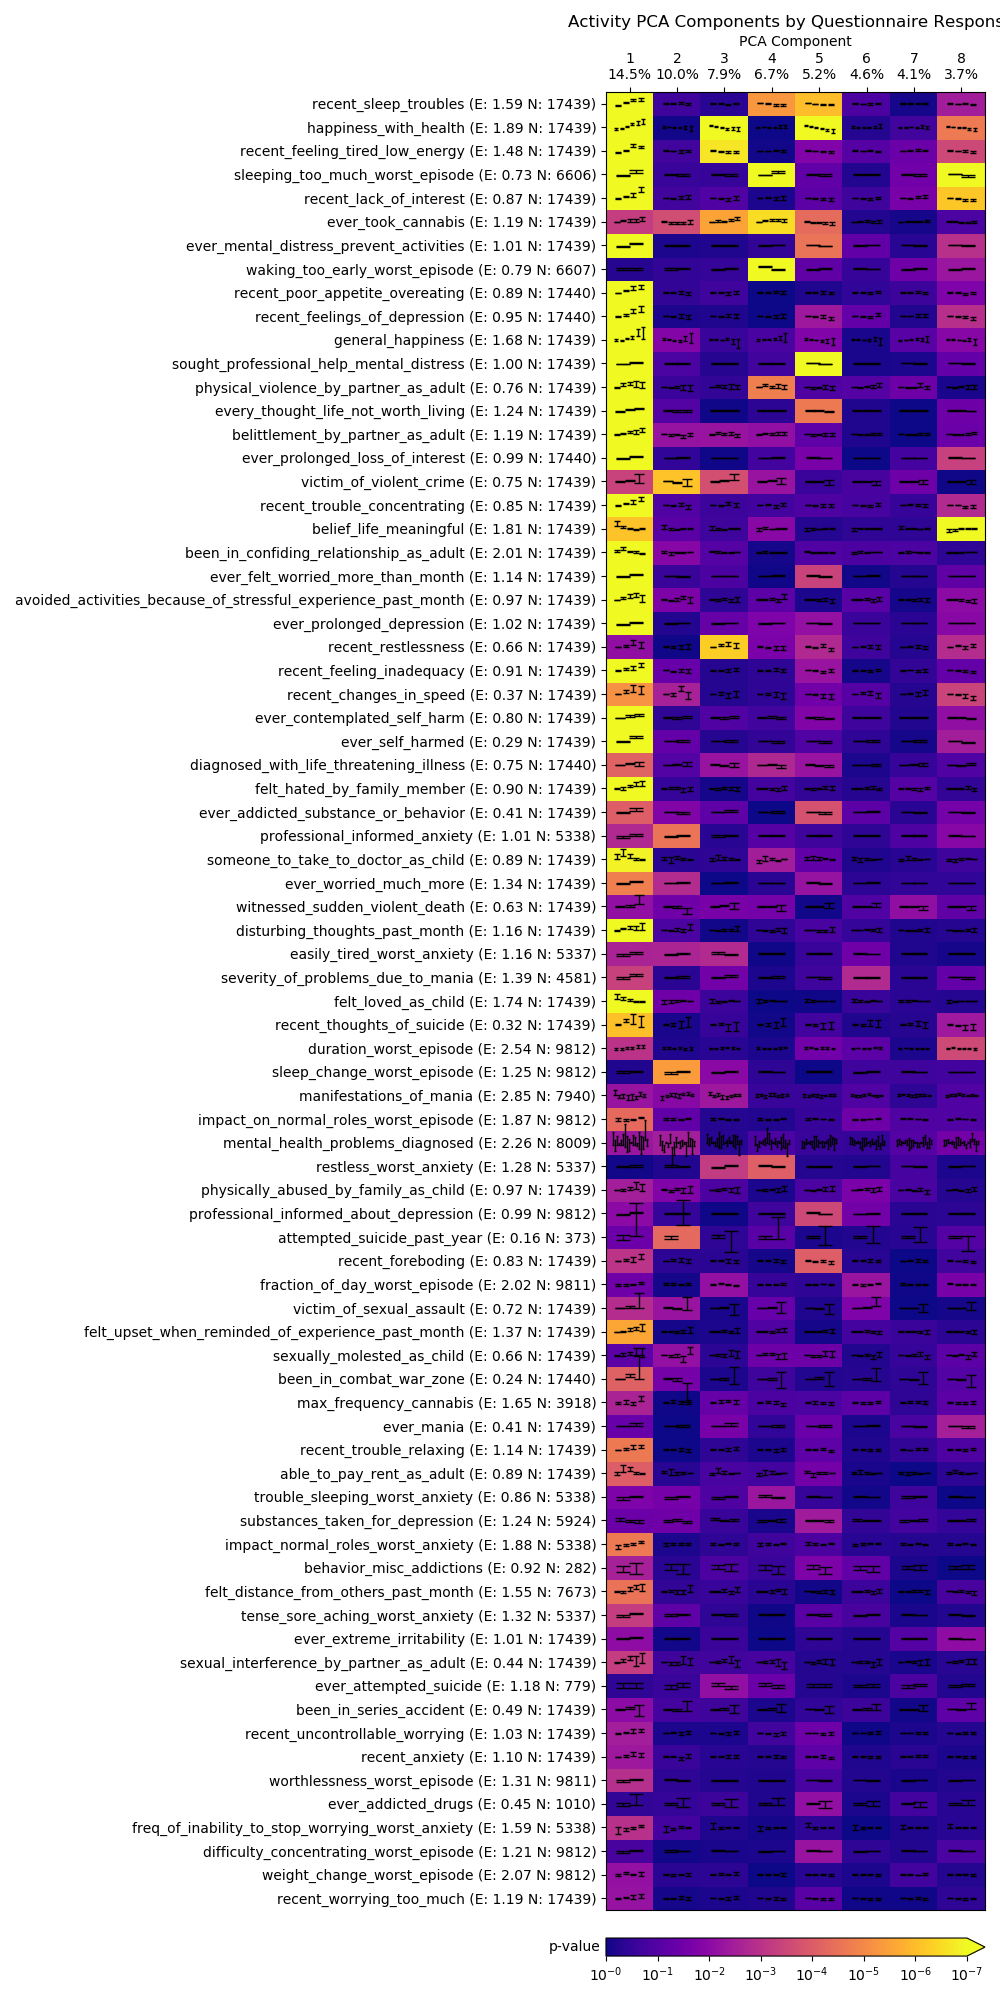

In [111]:
fig, ax = pylab.subplots(figsize=(10,20))
scale = 0.3
num_pca_components = 8

# Gather fields that have at least one significant p-value
use_fields = []
all_ps = {}
for field in mental_health_questions:
    ps = numpy.array([corr_with_PCAs[i]['p'].loc[field] for i in range(num_pca_components)]).astype(float)
    if (ps < 0.01).any():
        use_fields.append(field)
        all_ps[field] = ps
all_ps = pandas.DataFrame(all_ps).T

# Order the rows to make them more similar to neighbors
#field_ordering = numpy.lexsort(numpy.rot90((all_ps < 1e-3).to_numpy()))
field_ordering = numpy.argsort((-numpy.log10(all_ps)).sum(axis=1))
#field_ordering = hierarchy.leaves_list(hierarchy.linkage((all_ps).astype(float), metric="euclidean"))#, optimal_ordering=True))
use_fields = [use_fields[i] for i in field_ordering]

# Draw the background heatmap of p-values
X,Y = numpy.meshgrid(numpy.arange(all_ps.shape[1]+1), numpy.arange(len(use_fields)+1)-0.5,)
color_mesh = ax.pcolormesh(X,Y,
                  -numpy.log10(all_ps.loc[use_fields].to_numpy()),
                  vmin=0,
                  vmax=7,
                  cmap="plasma",
                 )

# Draw all the individual field's plots of values-by-response
for j, field in enumerate(use_fields):
    for i in range(num_pca_components):
        enrich_data = enrichment_with_PCAs[i][field]
        enrich = enrich_data['value']
        drop = enrich.index.intersection([f"{field}_{d}" for d in ["Prefer not to answer", "Prefer_not_to_answer", "Do not know", "Do_not_know"]])
        enrich = enrich.drop(drop)
        SE = enrich_data['SE'].loc[enrich.index]
        ax.errorbar(i+numpy.linspace(0.1,0.9, len(enrich)+2)[1:-1], enrich*scale + j, c='k', marker="", yerr=SE*2*scale,
                   linewidth=0, capsize=10/len(enrich), elinewidth=1)

ax.set_title("Activity PCA Components by Questionnaire Responses")
ax.set_yticks(numpy.arange(len(use_fields)))
ax.set_yticklabels([f"{field} (E: {question_data[field]['entropy']:0.2f} N: {int(question_data[field]['total'])})" for field in use_fields])
ax.set_ylim(-0.5,len(use_fields)-0.5)
ax.set_xticks(numpy.arange(all_ps.shape[1])+0.5)
#ax.set_xticklabels(numpy.arange(all_ps.shape[1])+1)
ax.set_xticklabels([f"{i+1}\n{x:0.1%}" for i,x in enumerate(pca.explained_variance_ratio_[:num_pca_components])])
ax.set_xlabel("PCA Component")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

#ax_bottom.yaxis.set_ticks_position('none')

colorbar = fig.colorbar(color_mesh, shrink=1/1, orientation='horizontal', fraction=0.01, pad=0.015, extend='max', format="$10^{-%.0f}$")
colorbar.ax.set_ylabel("p-value", rotation='horizontal', horizontalalignment="right", verticalalignment="center")
fig.tight_layout()
fig.savefig(f"{OUTDIR}/activity_pca_by_response.svg")

<IPython.core.display.Javascript object>


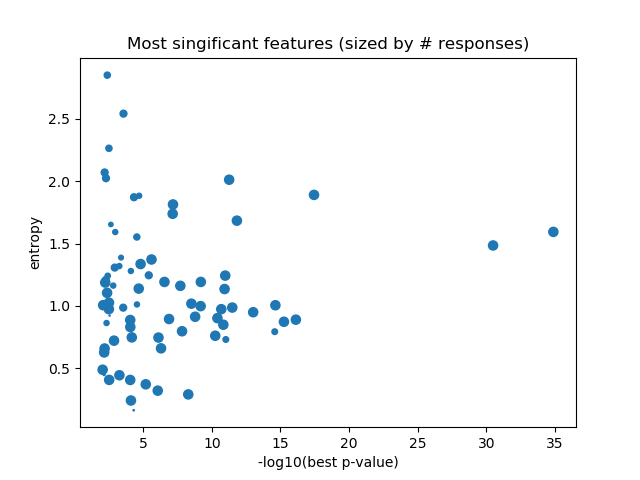

Text(0, 0.5, 'entropy')

In [112]:
# Scatter plot the p-values by their entropy and N
best_p = -numpy.log10(all_ps.min(axis=1))
entropies = numpy.array([question_data[field]['entropy'] for field in best_p.index])
totals = numpy.array([question_data[field]['total'] for field in best_p.index])

fig, ax = pylab.subplots()
ax.scatter(best_p, entropies, s=totals/400)
ax.set_title("Most singificant features (sized by # responses)")
ax.set_xlabel("-log10(best p-value)")
ax.set_ylabel("entropy")

In [110]:
# NOTE: this is deprecated and no longer works
# High-scoring depression
depression = (((mental_health.mental_health_problems_diagnosed_Depression == 1.0)
                & (mental_health['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] == 0.0)
                & (mental_health.mental_health_problems_diagnosed_Anorexia_nervosa == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Psychological_over-eating_or_binge-eating'] == 0.0))
    & ((mental_health.ever_attempted_suicide == 'Yes')
       | ((mental_health.number_depressed_periods >= 3)
          & ((mental_health.impact_on_normal_roles_worst_episode == 'A lot')
             | (mental_health.impact_on_normal_roles_worst_episode == 'Somewhat'))))
    & ~(mental_health.ever_addicted_drugs == 'Yes'))
depression = depression.loc[for_pca.index]

activity_depression = for_pca.loc[depression.index]#.select_dtypes(include=[numpy.number])

corr_depression = correlate(depression, activity_depression)
N_depression = activity_depression.count()

AttributeError: 'DataFrame' object has no attribute 'ever_attempted_suicide'

In [ ]:
# Bootstrap ps
bootstrap_corrs_depression = []
bootstrap_N_depression = 10 # TODO: increase this if we wnat to sue these
for n in range(bootstrap_N_depression):
    corr_perm = correlate(pandas.Series(numpy.random.permutation(depression), index=depression.index), activity_depression)
    bootstrap_corrs_depression.append(corr_perm)
bootstrap_corrs_depression = numpy.array(bootstrap_corrs_depression)
bootstrap_ps_depression = (numpy.sum(numpy.abs(bootstrap_corrs_depression) >= numpy.abs(corr_depression).to_numpy().reshape((1,-1)), axis=0) + 1) / (bootstrap_N_depression + 1)

In [ ]:
# Display depression <-> dist_from_pca_center correlations
highest_enriched_value_depression = pandas.DataFrame({colname: get_highest_enriched_value(col, depression )
                                for colname, col in activity_depression.items()}).T
depression_correlations = pandas.DataFrame( {"stat": corr_depression, "bootstrap_p":bootstrap_ps_depression, "N":N_depression, "most_enriched":highest_enriched_value_depression.category, "enrichment":highest_enriched_value_depression.value}).sort_values(by="bootstrap_p")
display(HTML(depression_correlations.to_html()))

In [ ]:
# Define the other conditions
anxiety = (((mental_health['mental_health_problems_diagnosed_Depression'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] == 1.0)
                & (mental_health['mental_health_problems_diagnosed_Anorexia_nervosa'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Psychological_over-eating_or_binge-eating'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Schizophrenia'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Any_other_type_of_psychosis_or_psychotic_illness'] == 0.0)
                & (mental_health[ 'mental_health_problems_diagnosed_Mania,_hypomania,_bipolar_or_manic-depression'] == 0.0))
            & ~(mental_health.ever_addicted_drugs == 'Yes')
            & ((mental_health.longest_period_worried > 1) | (mental_health.longest_period_worried == -999))
          )
anxiety = anxiety.loc[for_pca.index]

mania = (((mental_health['mental_health_problems_diagnosed_Depression'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Anorexia_nervosa'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Psychological_over-eating_or_binge-eating'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Schizophrenia'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Any_other_type_of_psychosis_or_psychotic_illness'] == 0.0)
                & (mental_health[ 'mental_health_problems_diagnosed_Mania,_hypomania,_bipolar_or_manic-depression'] == 1.0))
            & ~(mental_health.ever_addicted_drugs == 'Yes')
            & ((mental_health.ever_mania == 'Yes'))
        )
mania = mania.loc[for_pca.index]
         
psychosis = (((mental_health['mental_health_problems_diagnosed_Depression'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Anorexia_nervosa'] == 0.0)
                & (mental_health['mental_health_problems_diagnosed_Psychological_over-eating_or_binge-eating'] == 0.0)
                & ((mental_health['mental_health_problems_diagnosed_Schizophrenia'] == 1.0)
                    | (mental_health['mental_health_problems_diagnosed_Any_other_type_of_psychosis_or_psychotic_illness'] == 1.0))
                & (mental_health[ 'mental_health_problems_diagnosed_Mania,_hypomania,_bipolar_or_manic-depression'] == 0.0))
            & ~(mental_health.ever_addicted_drugs == 'Yes')
            )
psychosis = psychosis.loc[for_pca.index]

control = (((mental_health['mental_health_problems_diagnosed_Depression'] != 1.0)
                & (mental_health['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] != 1.0)
                & (mental_health['mental_health_problems_diagnosed_Anorexia_nervosa'] != 1.0)
                & (mental_health['mental_health_problems_diagnosed_Psychological_over-eating_or_binge-eating'] != 1.0)
                & (mental_health['mental_health_problems_diagnosed_Schizophrenia'] != 1.0)
                & (mental_health['mental_health_problems_diagnosed_Any_other_type_of_psychosis_or_psychotic_illness'] != 1.0)
                & (mental_health[ 'mental_health_problems_diagnosed_Mania,_hypomania,_bipolar_or_manic-depression'] != 1.0))
         & (~mental_health.date_of_mental_health_questionnaire.isna())
         & (~(mental_health.ever_addicted_drugs == 'Yes'))
         & (mental_health.ever_mania == 'No')
         & (mental_health.ever_prolonged_depression == 'No')
)
control = control.loc[for_pca.index]

In [ ]:
categories = {"psychosis": psychosis, "mania": mania, "anxiety": anxiety, "depression": depression, "control": control}
def get_category(i):
    for cat, vector in categories.items():
        if vector[i]:
            return cat
    return float("NaN")
category = pandas.Series([get_category(i) for i in for_pca.index],
    index = for_pca.index).astype("category")
category = category.cat.reorder_categories(["control", "depression", "anxiety", "mania", "psychosis"])
mental_health_category = pandas.DataFrame({"category": category})
for i, coord in enumerate(pca_coords.T):
    mental_health_category[f'pca_{i}'] = coord
mental_health_category['dist_from_pca_center'] = dist_from_pca_center
import collections; collections.Counter(category)

In [ ]:
pylab.figure()
sns.scatterplot(x="pca_0", y="pca_1", hue="category", data=mental_health_category[mental_health_category.category != 'control'])
ax = pylab.gca()
ellipse = pylab.mpl.patches.Ellipse(center[:2], 2*radii[0], 2*radii[1], edgecolor="k", facecolor='none')
ellipse.set_transform(ax.transData)
ax.add_patch(ellipse)
pylab.show()

In [ ]:
pylab.figure(figsize=(7,7))
var = "category"
mental_health_for_pca = mental_health.loc[for_pca.index]
labels = mental_health_category[var].dropna().unique()
by_category = [dist_from_pca_center[mental_health_category[var] == cat] for cat in labels]
pylab.boxplot(by_category, labels=labels, notch=True)
pylab.xticks(rotation=45)
pylab.subplots_adjust(bottom=0.3)
pylab.ylabel("Distance from PCA center")
pylab.show()

In [ ]:
# Check correlation of condition with PCA distance
category_v_pca_dist = sm.OLS.from_formula(formula="dist_from_pca_center ~ category", data=mental_health_category).fit()
category_v_pca_dist.summary()

In [ ]:
# Find differences between the categories
def compare(cat1, cat2):
    in_cat1 = mental_health_category.category == cat1
    in_cat2 = mental_health_category.category == cat2
    either = in_cat1 | in_cat2
    endog = for_pca[either]
    results = {}
    for var in endog:
        constant = numpy.ones(in_cat1[either].shape)
        exog = numpy.vstack( [constant, in_cat1[either].astype('int')] ).T
        res = sm.OLS(endog = endog[var], exog = exog).fit()
        contrast = [0,1] # Difference between categories is 0
        test = res.f_test(contrast)
        mean1 = endog.loc[in_cat1[either], var].mean()
        mean2 = endog.loc[in_cat2[either], var].mean()
        total_mean = for_pca[var].mean()
        results[var] = {"p": test.pvalue, f"{cat1}_mean":mean1, f"{cat2}_mean":mean2, "overall_mean":total_mean}
    return pandas.DataFrame(results).T.sort_values(by="p")
res = compare("control", "depression")
display(HTML(res.to_html()))

In [ ]:
res = compare("depression", "anxiety")
display(HTML(res.to_html()))

In [ ]:
total = (~mental_health.loc[for_pca.index].date_of_mental_health_questionnaire.isna()).sum()
for c in [col for col in mental_health.columns if ("mental_health_problems_diagnosed" in col)]:
    print(c, mental_health.loc[for_pca.index, c].sum())

In [ ]:
(mental_health.loc[for_pca.index]['mental_health_problems_diagnosed_Anxiety,_nerves_or_generalized_anxiety_disorder'] *
 mental_health.loc[for_pca.index]['mental_health_problems_diagnosed_Depression']).sum()
control.sum()

In [ ]:
import glob
import re
activity_files = glob.glob("../processed/acc_analysis/*_90001_0_0-timeSeries.csv.gz")
non_outlier_IDs = []
outlier_IDs = []
for filename in activity_files:
    ID = int(re.search("([\d]*)_90001_0_0-timeSeries.csv.gz", filename).groups()[0])
    if ID in outliers.index:
        if outliers[ID]:
            outlier_IDs.append(ID)
        else:
            non_outlier_IDs.append(ID)
#",".join([f"{x}_90001_0_0-timeSeries.csv.gz" for x in outliers.index[numpy.where(outliers)[0]]])
len(outlier_IDs)

In [ ]:
# Generate PDFs of the outlier vs non-outlier plots
#NOTE: slowish!
n = 20 # Number of plots to include
pylab.ioff()# Hide plots
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{OUTDIR}/activity_non_outliers.pdf")
for ID in non_outlier_IDs[:10]:
    visualize.visualize(f"../processed/acc_analysis/{ID}_90001_0_0-timeSeries.csv.gz", figsize=(9,7), show=False)
    pdf.savefig(fig=pylab.gcf())
pdf.close()
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{OUTDIR}/activity_outliers.pdf")
for ID in outlier_IDs[:10]:
    visualize.visualize(f"../processed/acc_analysis/{ID}_90001_0_0-timeSeries.csv.gz", figsize=(9,7), show=False)
    pdf.savefig(fig=pylab.gcf())
    pylab.close()
pdf.close()
pylab.ion()

In [ ]:
# Display a random plot of activity
import visualize
ID = numpy.random.choice(outlier_IDs)
visualize.visualize(f"../processed/acc_analysis/{ID}_90001_0_0-timeSeries.csv.gz", figsize=(9,7))
i = numpy.where(outliers.index == ID)[0][0]
print("dist_from_pca_center:", dist_from_pca_center[i])

In [ ]:
# View details of a single individual by ID
ID = 2055584
i = list(for_pca.index).index(ID)
print(f"PCA Coordinates:{pca_coords[i]}")
pandas.DataFrame({"value": for_pca.loc[ID], "zscore": ((for_pca - for_pca.mean(axis=0))/for_pca.std(axis=0)).loc[ID], "mean": for_pca.mean(axis=0), "std": for_pca.std(axis=0)})


In [ ]:
pylab.figure()
outliers.rename("outlier", inplace=True)
with_outlier = for_pca.join(outliers)
sns.boxplot(y="main_sleep_offset_avg", data=with_outlier, x=category, notch=True)

In [ ]:
full_activity.main_sleep_onset_avg.describe()

In [ ]:
pylab.figure()
sns.violinplot(y="main_sleep_onset_avg", data=full_activity, x=full_activity.index.map(ukbb.sex))
#sns.violinplot(y=pandas.Series(dist_from_pca_center, index=for_pca.index), data=for_pca, x=for_pca.index.map(ukbb.sex))
pylab.show()

# Low Rank Regression

In [113]:
#### Perform a low-rank regression on the data
def low_rank_regression(A, Z, rank):
    """
    Solve for Theta minimizing L2 error in 
    Z ~ A Theta
    under the constraint that Theta has at most the given rank
    Let n be the number of observations, p the number of exogenous variables,
    and k the number of endogenous variables

    A - the design matrix, n x p
    Z - the data matrix, n x k
    rank - the rank of Theta

    Returns: Theta, p x k and
             factors, p x rank of loadings for the X variables for the given number of factors extracted
             SSR, the squared sum of residual errors after the fit Z = A Theta

    Assumes: the rank of A is at least `rank`

    See:
    "Optimal Exact Least Squares Rank Minimization" Shuo Xiang, Yunzhang Zhu, Xiaotong Shen, Jieping Ye
    """

    n, k = Z.shape
    assert A.shape[0] == n
    n,p = A.shape
    assert rank <= min(n,k,p)

    U,D,VT = numpy.linalg.svd(A, full_matrices=False)

    # Epsilon tolerance as in numpy.matrix_rank
    tolerance = numpy.finfo(A.dtype).eps * A.max() * max(A.shape)
    # Rank of A from the svd decomposition
    r = numpy.sum(D > tolerance)
    assert rank <= r

    W = U.T @ Z
    W_first_r_rows = W[:r]
    D_first_r_inv = numpy.diag(1/D[:r])

    W_low_rank = project_to_low_rank(W_first_r_rows, rank)
    Y_star = numpy.vstack(( D_first_r_inv @ W_low_rank, numpy.zeros(((p-r),k)) ))
    Theta = VT.T @ Y_star

    UTheta, DTheta, VTTheta = numpy.linalg.svd(Theta, full_matrices=False)
    factors = UTheta[:,:rank]
    
    SSR = numpy.sum( (Z - A @ Theta)**2 )
    return Theta, factors, SSR

def project_to_low_rank(M, rank):
    ''' Project a matrix to specified rank by SVD truncation '''
    U,D,VT = numpy.linalg.svd(M, full_matrices=False)
    D[rank:] = 0
    return U @ numpy.diag(D) @ VT

def assess_lowrank_structure(A, Z):
    """
    Solve for latent factors in
    Z ~ A Theta
    Ordering the factors by the the rank for which they first appear in Theta

    Let n be the number of observations, p the number of exogenous variables,
    and k the number of endogenous variables

    A - the design matrix, n x p
    Z - the data matrix, n x k
    
    Returns: Theta, equivalent to the OLS Theta solving  Z ~ A Theta
             factors, p x k array whose ith column is the loading of the ith latent factor
             SSR, an length k array of squared sum of residual errors after the fit Z = A Theta using just the first i factors

    Assumes: the rank of A is at least `rank`

    See:
    "Optimal Exact Least Squares Rank Minimization" Shuo Xiang, Yunzhang Zhu, Xiaotong Shen, Jieping Ye
    
    This uses the observation, using the solution in their paper, that the spaces colspan(Theta_k) are nested
    when Theta_k is the minimizer for Z ~ A Theta with Theta of rank at most k.
    Hence it makes sense to ask for the kth factor: a vector in colspan(Theta_k) that is orthogonal to colspan(Theta_{k-1}).
    """

    n, k = Z.shape
    assert A.shape[0] == n
    n,p = A.shape
    assert rank <= min(n,k,p)

    U,D,VT = numpy.linalg.svd(A, full_matrices=False)

    # Epsilon tolerance as in numpy.matrix_rank
    tolerance = numpy.finfo(A.dtype).eps * A.max() * max(A.shape)
    # Rank of A from the svd decomposition
    r = numpy.sum(D > tolerance)
    assert rank <= r

    W = U.T @ Z
    W_first_r_rows = W[:r]
    D_first_r_inv = numpy.diag(1/D[:r])

    U_W, D_W, VT_W = numpy.linalg.svd(W_first_r_rows, full_matrices=False)
    
    def gram_schmidt(vectors):
        ''' Gives orthogonal basis given a set of vectors, preserving the flag of subspaces span(v_1, ... v_k) '''
        out = numpy.empty(vectors.shape)
        for i in range(vectors.shape[1]):
            v = vectors[:,i:i+1]
            if i > 0:
                projection = sum(out[:,j:j+1] * (out[:,j:j+1].T @ v) for j in range(i))
                v = v - projection
            v = v / numpy.sqrt(numpy.sum(v**2))
            out[:,i:i+1] = v
        return out
    
    # Each factor is obtained by taking the ith column of U_W and using that instead of W
    # these are sorted (descending) by the singular values of W and so appear in the order
    # that the factors are added as you increase the rank of the low rank approximation
    factors = [VT.T @ numpy.vstack( (D_first_r_inv @ U_W[:,i:i+1], numpy.zeros((p-r,1)) ))
                           for i in range(r)]
    factors = numpy.concatenate(factors, axis=1)
    factors = gram_schmidt(factors)
    
    # Solve for the whole Theta
    Y_star = numpy.vstack(( D_first_r_inv @ W_first_r_rows, numpy.zeros(((p-r),k)) ))
    Theta = VT.T @ Y_star

    
    SSR = numpy.sum( (Z - A @ Theta)**2 )
    return Theta, factors, SSR

In [114]:
# Run the low-rank regression
RANK = 5

# Low-rank regression needs all the data to be non-nan
# We will fit on just the questions that all people were asked (assuming they took the questionnaire at all)
has_mental_health_data = ~mental_health.ever_mania_Yes.isna()
mental_health_lrr = mental_health[has_mental_health_data].dropna(axis='columns', how='any')
index = mental_health_lrr.index.intersection(for_pca.index)
mental_health_lrr = mental_health_lrr.loc[index]
mental_health_lrr = (mental_health_lrr - mental_health_lrr.mean(axis=0)) / mental_health.std(axis=0)
mental_health_lrr.dropna("columns", inplace=True)
activity_lrr = for_pca.loc[index]
activity_lrr.drop(columns=["total_sleep_avg"], inplace=True) # Drop columns that are linearly dependent on others
activity_lrr = (activity_lrr - activity_lrr.mean(axis=0)) / activity_lrr.std(axis=0)
#activity_lrr['constant'] = 1
SSTOT = numpy.sum( (mental_health_lrr.to_numpy() - mental_health_lrr.to_numpy().mean(axis=0))**2 )

# Run the LRR
weights, factors, SSR = low_rank_regression(activity_lrr.to_numpy(), mental_health_lrr.to_numpy(), rank=RANK)
print(f"Computed Low-Rank Regression (rank={RANK}) with SSR of {SSR:0.3e} and R^2 {1 - SSR/SSTOT:0.4f}")


# Run OLS instead
ols_fit = sm.OLS(exog=activity_lrr.to_numpy(), endog=mental_health_lrr.to_numpy()).fit()
ols_SSR = numpy.sum( (mental_health_lrr.to_numpy() - activity_lrr.to_numpy() @ ols_fit.params)**2 )
print(f"OLS has SSR of {ols_SSR:0.3e} with R^2 {1 - ols_SSR/SSTOT:0.4f}")

# Fit by means only
mean_fit = mental_health_lrr.mean(axis=0).to_numpy()[None,:]
mean_fit_SSR = numpy.sum( (mental_health_lrr.to_numpy() - mean_fit)**2 )
print(f"Mean fit has SSR of {mean_fit_SSR:0.3e} with R^2 {1 - mean_fit_SSR/SSTOT:0.4f}")

Computed Low-Rank Regression (rank=5) with SSR of 4.661e+06 and R^2 0.0022
OLS has SSR of 4.648e+06 with R^2 0.0050
Mean fit has SSR of 4.671e+06 with R^2 0.0000


In [115]:
# Analyze the LRR results
factors = pandas.DataFrame(factors, index=activity_lrr.columns)
factors['average'] = factors.abs().sum(axis=1) /RANK
#fig, ax = pylab.subplots()
display(HTML(factors.sort_values(by="average", ascending=False).to_html()))

,0,1,2,3,4,average
main_sleep_ratio_avg,-0.382008,-0.382859,0.006749,0.232131,-0.196529,0.240055
acceleration_RA,-0.501278,-0.031641,0.289220,-0.085074,-0.270712,0.235585
WASO_avg,-0.330589,-0.422913,-0.100894,0.064979,0.105903,0.205056
MET_peak_value_avg,0.113155,-0.092000,0.594084,0.001001,0.166886,0.193425
main_sleep_duration_std,0.165903,-0.479471,-0.064114,-0.136139,0.100644,0.189254
moderate_peak_value_avg,-0.132809,0.161961,-0.472036,0.057047,-0.116180,0.188007
main_sleep_offset_std,-0.212631,0.246051,-0.085327,-0.345556,-0.012732,0.180459
total_sleep_std,-0.015116,0.236147,0.272265,0.288699,0.026098,0.167665
sedentary_peak_value_avg,-0.106153,-0.110317,-0.148085,0.211663,0.239015,0.163047
sleep_peak_quality_avg,-0.167844,0.078900,0.090766,0.119561,-0.251484,0.141711


In [116]:
# Angle between the various components and the given RANK-dimensional subspace
angles = numpy.empty( len(factors) )
correlations = numpy.empty( len(factors) )
regressed_values = activity_lrr @ factors
for i, var in enumerate(factors.index):
    vector = numpy.zeros( (len(factors),1))
    vector[i] = 1
    angles[i] = scipy.linalg.subspace_angles(vector, factors)
    correlations[i] = scipy.linalg.subspace_angles(activity_lrr[[var,]].to_numpy(), regressed_values.to_numpy())
LRR_var_contributions = pandas.DataFrame({"angle": angles, "corr":numpy.cos(correlations)}, index=factors.index
                                        ).sort_values(by="corr", ascending=False)
display(HTML(LRR_var_contributions.to_html()))

,angle,corr
acceleration_RA,0.855130,0.766036
sedentary_RA,1.110566,0.737254
main_sleep_duration_std,0.954723,0.717706
MET_RA,1.365580,0.708261
total_sleep_std,1.024132,0.702136
main_sleep_offset_avg,1.319735,0.684520
main_sleep_offset_std,0.929207,0.682194
main_sleep_ratio_avg,0.901004,0.661955
WASO_avg,0.976015,0.659212
sleep_peak_quality_avg,1.199619,0.658247


In [117]:
# Vary the rank
factors_by_rank = []
for rank in range(1,11):
    _, factors_, _ = low_rank_regression(activity_lrr.to_numpy(), mental_health_lrr.to_numpy(), rank=rank)
    factors_by_rank.append(factors_)

In [118]:
# Compute all the factors in the ascending sequence of low rank approximations
_, factors, SSR = assess_lowrank_structure(activity_lrr.to_numpy(), mental_health_lrr.to_numpy())

# Correlate the univariate variables with the factors
def corr(activity, target):
    corrs = [numpy.sum(col * target) / numpy.linalg.norm(col) / numpy.linalg.norm(target)
                    for _, col in activity_lrr.iteritems()]
    return pandas.Series(corrs, index=activity.columns)
#factor_correlations = pandas.DataFrame({i:corr(activity_lrr, activity_lrr @ factors[:,i])
#                                            for i in range(factors.shape[1])})

factor_correlations = numpy.array([[numpy.corrcoef(activity_col,  (activity_lrr @ factor))[1,0]
                                           for factor in factors.T]
                                    for col, activity_col in activity_lrr.iteritems()])
factor_correlations = pandas.DataFrame(factor_correlations, index=activity_lrr.columns)

<IPython.core.display.Javascript object>


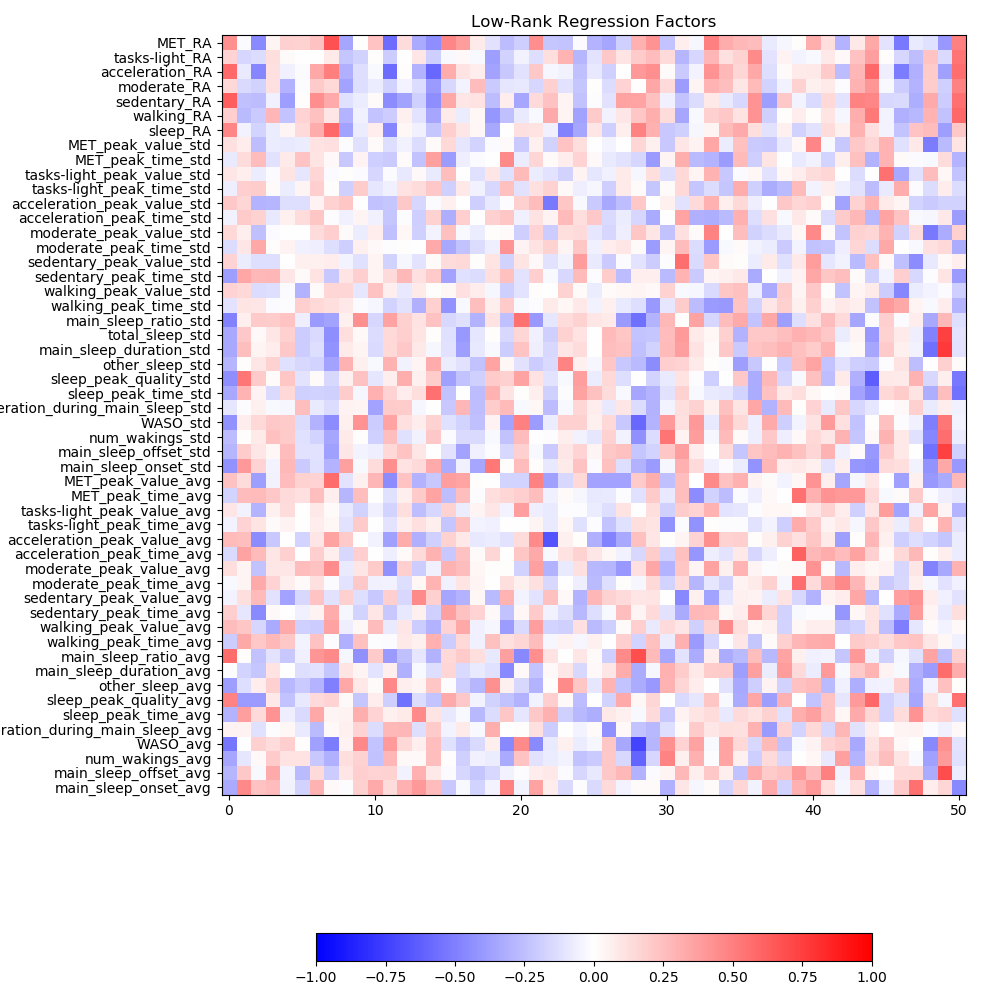

In [119]:
fig, ax = pylab.subplots(figsize=(10,10))

g = ax.imshow(factor_correlations, vmin=-1,vmax=1, cmap="bwr")
ax.set_yticks(numpy.arange(factor_correlations.shape[0]))
ax.set_yticklabels(activity_lrr.columns)
ax.set_ylim(-0.5, factors.shape[0]-0.5)
ax.set_title("Low-Rank Regression Factors")
fig.colorbar(g, fraction=0.03, orientation="horizontal")
fig.tight_layout()

# Random Forest Classifier

In [120]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(oob_score=True, n_estimators=1_000)
value = full_mental_health.loc[activity_lrr.index, 'ever_prolonged_depression'] == "Yes"
negatives = value[value == False].iloc[:5000].index
positives = value[value == True].iloc[:5000].index
indexes = negatives.union(positives)
fit = classifier.fit(activity_lrr.loc[indexes], value.loc[indexes])

In [121]:
fit.score(activity_lrr, value)
print(fit.oob_score_)
#value.describe()

0.5432


In [122]:
# Quite validation check against the remaining datapoints
# Note changes everytime the random forest model is run1
remaining = value[value == False].iloc[5000:7000].index.union(value[value==True].iloc[5000:7000].index)
score = fit.score(activity_lrr.loc[remaining], value.loc[remaining])
print(f"Random Forests accuracy score: {score:0.1%}")

Random Forests accuracy score: 56.0%


In [123]:
feature_importances = pandas.Series(fit.feature_importances_, index=activity_lrr.columns)
print(feature_importances.sort_values(ascending=False))

moderate_RA                           0.025289
acceleration_peak_value_std           0.021531
tasks-light_RA                        0.021036
walking_peak_value_std                0.020941
walking_RA                            0.020661
walking_peak_time_avg                 0.020573
tasks-light_peak_time_avg             0.020510
tasks-light_peak_value_std            0.020457
moderate_peak_value_std               0.020157
acceleration_during_main_sleep_std    0.020087
sedentary_peak_time_std               0.020064
tasks-light_peak_time_std             0.019936
tasks-light_peak_value_avg            0.019866
walking_peak_time_std                 0.019830
walking_peak_value_avg                0.019682
sleep_RA                              0.019628
acceleration_during_main_sleep_avg    0.019595
sedentary_peak_value_std              0.019562
acceleration_peak_time_std            0.019549
num_wakings_std                       0.019505
main_sleep_onset_std                  0.019443
sedentary_pea